# Data Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import collections
import torch
import random
import math
import time
print("Using torch", torch.__version__)

torch.cuda.empty_cache()

Using torch 2.1.0+cu121


In [2]:
from torch_geometric.datasets import MovieLens100K, IGMCDataset

mov = IGMCDataset('/tmp/douban', 'Douban')[0]

Processing...
Done!


In [3]:
num_nodes = mov.num_nodes
print('dataset has {} nodes'.format(num_nodes))

num_edges = mov.num_edges
print('dataset has {} edges'.format(num_edges))

num_users = mov['user'].x.shape[0]
print('dataset has {} users'.format(num_users))

num_movies = mov['item'].x.shape[0]
print('dataset has {} items'.format(num_movies))

dataset has 6000 nodes
dataset has 246404 edges
dataset has 3000 users
dataset has 3000 items


# Configurations

In [25]:
use_edge_weights = True  #@param {type: "boolean"}: Determine whether model uses edge weights as attention coefficients

config_dict = {
    "num_samples_per_user": 100,
    "num_users": num_users,

    "epochs": 50,
    "batch_size": 60,
    "lr": 0.001,
    "weight_decay": 1,

    "embedding_size": 64,
    "num_layers": 3,
    "mf_rank": 8,

    "minibatch_per_print": 100,
    "epochs_per_print": 1,

    "val_frac": 0.2,
    "test_frac": 0.1,

    "K": 10,

    "model_name": "model.pth"
}

In [5]:
def edge_list_to_adjacency(edge_index, ratings, user_num, item_num):
    # Create an empty adjacency matrix
    adjacency = torch.zeros(user_num, item_num)
    
    # Fill the adjacency matrix using the edge list
    for i in range(edge_index.size(1)):
        start_node = edge_index[0, i].item()
        end_node = edge_index[1, i].item()
        #adjacency[start_node, end_node] = ratings[i]
        
        if ratings[i] > rating_threshold:
            adjacency[start_node, end_node] = 1  # Assuming it's an unweighted graph
    
    return adjacency

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_edge_index = edge_list_to_adjacency(
    mov[('user', 'rates', 'item')]['edge_index'],
    mov[('user', 'rates', 'item')]['rating'],
    num_users,
    num_movies
).to(device)

# Model Code

In [24]:
from torch import nn, optim, Tensor
from torch_geometric.nn import MessagePassing
from torch_geometric.typing import Adj
import torch.nn.functional as F

class LightGCNConv(MessagePassing):
    r"""The neighbor aggregation operator from the `"LightGCN: Simplifying and
    Powering Graph Convolution Network for Recommendation"
    <https://arxiv.org/abs/2002.02126#>`_ paper

    Args:
        in_channels (int): Size of each input sample, or :obj:`-1` to derive
            the size from the first input(s) to the forward method.
        out_channels (int): Size of each output sample.
        num_users (int): Number of users for recommendation.
        num_items (int): Number of items to recommend.
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, in_channels: int, out_channels: int,
                 num_users: int, num_items: int, **kwargs):
        super(LightGCNConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.num_users = num_users
        self.num_items = num_items

        self.reset_parameters()

    def reset_parameters(self):
        pass  # There are no layer parameters to learn.

    def forward(self, x: Tensor, edge_index: Adj) -> Tensor:
        """Performs neighborhood aggregation for user/item embeddings."""
        user_item = \
                torch.zeros(self.num_users, self.num_items, device=x.device)
        user_item[edge_index[:, 0], edge_index[:, 1]] = 1 # global_edge_index[edge_index[:, 0], edge_index[:, 1]]

        att = \
                torch.zeros(self.num_users, self.num_items, device=x.device)
        att[edge_index[:, 0], edge_index[:, 1]] = global_edge_index[edge_index[:, 0], edge_index[:, 1]]

        user_neighbor_counts = torch.sum((user_item > 0), axis=1)
        item_neightbor_counts = torch.sum((user_item > 0), axis=0)

        # Compute weight for aggregation: 1 / sqrt(N_u * N_i)

        if use_edge_weights:
            weights = att / torch.sqrt(
                user_neighbor_counts.repeat(self.num_items, 1).T \
                * item_neightbor_counts.repeat(self.num_users, 1))
        else:
            weights = (user_item > 0) / torch.sqrt(
                    user_neighbor_counts.repeat(self.num_items, 1).T \
                    * item_neightbor_counts.repeat(self.num_users, 1))
        
        weights = torch.nan_to_num(weights, nan=0)
        out = torch.concat((weights.T @ x[:self.num_users],
                            weights @ x[self.num_users:]), 0)
        return out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)


In [7]:
class LightGCN(nn.Module):
    def __init__(self, 
                 config: dict,
                 device=None,
                 **kwargs):
        super().__init__()

        self.num_users  = config["n_users"]
        self.num_items  = config["m_items"]
        self.embedding_size = config["embedding_size"]
        self.in_channels = self.embedding_size
        self.out_channels = self.embedding_size
        self.num_layers = config["num_layers"]

        # 0-th layer embedding.
        self.embedding_user_item = torch.nn.Embedding(
            num_embeddings=self.num_users + self.num_items,
            embedding_dim=self.embedding_size)
        self.alpha = None

        # random normal init seems to be a better choice when lightGCN actually
        # don't use any non-linear activation function
        nn.init.normal_(self.embedding_user_item.weight, std=0.1)
        print('use NORMAL distribution initilizer')

        self.f = nn.Sigmoid()

        self.convs = nn.ModuleList()
        self.convs.append(LightGCNConv(
                self.embedding_size, self.embedding_size,
                num_users=self.num_users, num_items=self.num_items, **kwargs))

        for _ in range(1, self.num_layers):
            self.convs.append(
                LightGCNConv(
                        self.embedding_size, self.embedding_size, 
                        num_users=self.num_users, num_items=self.num_items,
                        **kwargs))

        self.device = None
        if device is not None:
            self.convs.to(device)
            self.device = device

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x: Tensor, edge_index: Adj, *args, **kwargs) -> Tensor:
        xs: List[Tensor] = []

        edge_index = torch.nonzero(edge_index)
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index, *args, **kwargs)
            if self.device is not None:
                x = x.to(self.device)
            xs.append(x)
        xs = torch.stack(xs)
        
        self.alpha = 1 / (1 + self.num_layers) * torch.ones(xs.shape)
        if self.device is not None:
            self.alpha = self.alpha.to(self.device)
            xs = xs.to(self.device)
        x = (xs * self.alpha).sum(dim=0)  # Sum along K layers.
        return x

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_layers={self.num_layers})')

# Utility Functions

In [8]:
def getUsersRating(model, users, data):
    """ Get the embedding of users
    INPUT:
        model: the LightGCN model you are training on
        users: this is the user index (note: use 0-indexed and not user number,
            which is 1-indexed)
        data: the entire data, used to fetch all users and all items
    """
    all_users_items = model(model.embedding_user_item.weight.clone(), global_edge_index)
    #print("USERS: ", users)
    #print("ALL USERS ITMES: ", all_users_items)
    #print("ALL USERS SHAPE: ", all_users_items.shape)
    all_users = all_users_items[:len(data["user"].x)]
    items_emb = all_users_items[len(data["user"].x):]
    users_emb = all_users[users.long()]
    rating = model.f(torch.matmul(users_emb, items_emb.t()))
    #print("RATING: ", rating)
    return rating

def getEmbedding(model, users, pos, neg, data, mask):
    """
    INPUT:
        model: the LightGCN model you are training on
        users: this is the user index (note: use 0-indexed and not user number,
            which is 1-indexed)
        pos: positive index corresponding to an item that the user like
        neg: negative index corresponding to an item that the user doesn't like
        data: the entire data, used to fetch all users and all items
        mask: Masking matrix indicating edges present in the current
            train / validation / test set.
    """
    # assuming we always search for users and items by their indices (instead of
    # user/item number)
    all_users_items = model(model.embedding_user_item.weight.clone(),
                            global_edge_index * mask)
    # print(all_users_items)
    all_users = all_users_items[:len(data["user"].x)]
    all_items = all_users_items[len(data["user"].x):]
    users_emb = all_users[users]
    pos_emb = all_items[pos]
    neg_emb = all_items[neg]
    n_user = len(data["user"].x)
    users_emb_ego = model.embedding_user_item(users)
    # offset the index to fetch embedding from user_item
    pos_emb_ego = model.embedding_user_item(pos + n_user)
    neg_emb_ego = model.embedding_user_item(neg + n_user)
    return users_emb, pos_emb, neg_emb, users_emb_ego, pos_emb_ego, neg_emb_ego

# Loss Function

In [9]:
def bpr_loss(model, users, pos, neg, data, mask):
    """ 
    INPUT:
        model: the LightGCN model you are training on
        users: this is the user index (note: use 0-indexed and not user number,
            which is 1-indexed)
        pos: positive index corresponding to an item that the user like
            (0-indexed, note to index items starting from 0)
        neg: negative index corresponding to an item that the user doesn't like
        data: the entire data, used to fetch all users and all items
        mask: Masking matrix indicating edges present in the current
            train / validation / test set.
    OUTPUT:
        loss, reg_loss
    """
    # assuming we always sample the same number of positive and negative sample
    # per user
    assert len(users) == len(pos) and len(users) == len(neg)
    (users_emb, pos_emb, neg_emb, 
    userEmb0,  posEmb0, negEmb0) = getEmbedding(model, users.long(), pos.long(),
                                                neg.long(), data, mask)
    reg_loss = (1/2)*(userEmb0.norm(2).pow(2) + 
                        posEmb0.norm(2).pow(2)  +
                        negEmb0.norm(2).pow(2))/float(len(users))
    pos_scores = torch.mul(users_emb, pos_emb)
    pos_scores = torch.sum(pos_scores, dim=1)
    neg_scores = torch.mul(users_emb, neg_emb)
    neg_scores = torch.sum(neg_scores, dim=1)
    
    loss = torch.mean(torch.nn.functional.softplus(neg_scores - pos_scores))
    
    return loss, reg_loss

# Personalized Top K Evaluation

In [10]:
def personalized_topk(pred, K, user_indices, edge_index):
    """Computes TopK precision and recall.

    Args:
        pred: Predicted similarities between user and item.
        K: Number of items to rank.
        user_indices: Indices of users for each prediction in `pred`.
        edge_index: User and item connection matrix.

    Returns:
        Average Top K precision and recall for users in `user_indices`.
    """
    per_user_preds = collections.defaultdict(list)
    for index, user in enumerate(user_indices):
        per_user_preds[user.item()].append(pred[index].item())
    precisions = 0.0
    recalls = 0.0
    for user, preds in per_user_preds.items():
        while len(preds) < K:
            preds.append(random.choice(range(edge_index.shape[1])))
        top_ratings, top_items = torch.topk(torch.tensor(preds), K)
        correct_preds = edge_index[user, top_items].sum().item()
        total_pos = edge_index[user].sum().item()
        precisions += correct_preds / K
        recalls += correct_preds / total_pos if total_pos != 0 else 0
    num_users = len(user_indices.unique())
    return precisions / num_users, recalls / num_users


# Training, Validation, and Test

In [11]:
def _sample_pos_neg(data, mask, num_samples_per_user):
    """Samples (user, positive item, negative item) tuples per user.

    If a user does not have a postive (negative) item, we choose an item
    with unknown liking (an item without raw rating data).

    Args:
        data: Dataset object containing edge_index and raw ratings matrix.
        mask: Masking matrix indicating edges present in the current
            train / validation / test set.
        num_samples_per_user: Number of samples to generate for each user.

    Returns:
        torch.Tensor object of (user, positive item, negative item) samples.
    """
    print("=====Starting to sample=====")
    start = time.time()
    samples = []
    all_items = set(range(len(data["item"].x)))
    for user_index, user in enumerate(data["user"].x):
        #print("HERE: ", user_index, user)
        pos_items = set(
            torch.nonzero(global_edge_index[user_index])[:, 0].tolist())
        #print("POSITIVE: ", pos_items)
        unknown_items = all_items.difference(
                set(
                    torch.nonzero(global_edge_index[user_index])[:, 0].tolist()))
        neg_items = all_items.difference(
            set(pos_items)).difference(set(unknown_items))
        unmasked_items = set(torch.nonzero(mask[user_index])[:, 0].tolist())
        if len(unknown_items.union(pos_items)) == 0 or \
                len(unknown_items.union(neg_items)) == 0:
            continue
        for _ in range(num_samples_per_user):
            if len(pos_items.intersection(unmasked_items)) == 0:
                pos_item_index = random.choice(
                    list(unknown_items.intersection(unmasked_items)))
            else:
                pos_item_index = random.choice(
                    list(pos_items.intersection(unmasked_items)))
            if len(neg_items.intersection(unmasked_items)) == 0:
                neg_item_index = random.choice(
                    list(unknown_items.intersection(unmasked_items)))
            else:
                neg_item_index = random.choice(
                    list(neg_items.intersection(unmasked_items)))
            samples.append((user_index, pos_item_index, neg_item_index))
    end = time.time()
    print(f"=====Sampling completed (took {end - start} seconds)=====")
    return torch.tensor(samples, dtype=torch.int32)

def sample_pos_neg(data, train_mask, val_mask, test_mask, num_samples_per_user):
    """Samples (user, positive item, negative item) tuples per user.

    If a user does not have a postive (negative) item, we choose an item
    with unknown liking (an item without raw rating data).

    Args:
        data: Dataset object containing edge_index and raw ratings matrix.
        train_mask: Masking matrix indicating edges present in train set.
        val_mask: Masking matrix indicating edges present in validation set.
        test_mask: Masking matrix indicating edges present in test set.
        num_samples_per_user: Number of samples to generate for each user.

    Returns:
        torch.Tensor object of (user, positive item, negative item) samples for
        train, validation and test.
    """
    train_samples = _sample_pos_neg(data, train_mask, num_samples_per_user)
    val_samples = _sample_pos_neg(data, val_mask, num_samples_per_user)
    test_samples = _sample_pos_neg(data, test_mask, num_samples_per_user)
    return train_samples, val_samples, test_samples

In [12]:
n_users = mov['user'].x.shape[0]
m_items = mov['item'].x.shape[0]

def train_val_test_split(num_user, num_item, val_frac, test_frac):
    """
    Return two mask matrices (M, N) that represents edges present in the
    train and validation set
    """
    # get number of edges masked for training and validation
    num_train_replaced = round((test_frac+val_frac)*num_user*num_item)
    num_val_show = round(val_frac*num_user*num_item)

    # edges masked during training
    indices_user = np.random.randint(0, num_user, num_train_replaced)
    indices_item = np.random.randint(0, num_item, num_train_replaced)

    # sample part of edges from training stage to be unmasked during
    # validation
    indices_val_user = np.random.choice(indices_user, num_val_show)
    indices_val_item = np.random.choice(indices_item, num_val_show)

    train_mask = torch.ones(num_user, num_item)
    train_mask[indices_user, indices_item] = 0

    val_mask = train_mask.clone()
    val_mask[indices_val_user, indices_val_item] = 1

    test_mask = torch.ones_like(train_mask)

    return train_mask, val_mask, test_mask


train_mask, val_mask, test_mask = train_val_test_split(
    num_user = n_users,
    num_item = m_items,
    val_frac = config_dict["val_frac"],
    test_frac = config_dict["test_frac"]
)

In [13]:
model_config = {
    "n_users": n_users,
    "m_items": m_items,
    "embedding_size": config_dict["embedding_size"],
    "num_layers": config_dict["num_layers"],
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE: ", device)
lightGCN = LightGCN(model_config, device=device)

num_samples_per_user = config_dict["num_samples_per_user"]
epochs = config_dict["epochs"]
batch_size = config_dict["batch_size"]
lr = config_dict["lr"]
weight_decay = config_dict["weight_decay"]

lightGCN.to(device)

samples_train, samples_val, samples_test = sample_pos_neg(
    mov, train_mask, val_mask, test_mask, num_samples_per_user)

samples_train=samples_train.to(device)
samples_val=samples_val.to(device)
samples_test=samples_test.to(device)
train_mask=train_mask.to(device)
val_mask=val_mask.to(device)
test_mask=test_mask.to(device)
mov = mov.to(device)

print(f"#Training samples: {len(samples_train)}",
      f"#Validation samples: {len(samples_val)}",
      f"#Test samples: {len(samples_test)}")

optimizer = optim.Adam(lightGCN.parameters(), lr=lr)
print("Optimizer:", optimizer)

DEVICE:  cuda
use NORMAL distribution initilizer
=====Starting to sample=====
=====Sampling completed (took 25.21623992919922 seconds)=====
=====Starting to sample=====
=====Sampling completed (took 25.54411768913269 seconds)=====
=====Starting to sample=====
=====Sampling completed (took 25.954902172088623 seconds)=====
#Training samples: 300000 #Validation samples: 300000 #Test samples: 300000
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [15]:
epochs_tracked = []
train_topks = []
val_topks = []
bprs = []
K = config_dict["K"]

for epoch in range(epochs):
    print("Training on the {} epoch".format(epoch))
    lightGCN.train()
    loss_sum = 0
    # Shuffle the order of rows.
    samples_train = samples_train[torch.randperm(samples_train.size()[0])]
    for batch_idx in range(math.ceil(len(samples_train) / batch_size)):
        optimizer.zero_grad()

        current_batch = \
            samples_train[batch_idx*batch_size: (batch_idx+1)*batch_size]
        # Shuffle the order of rows.
        current_batch = current_batch[torch.randperm(current_batch.size()[0])]
        users = current_batch[:, 0:1]
        pos = current_batch[:, 1:2]
        neg = current_batch[:, 2:3]

        loss, reg_loss = bpr_loss(lightGCN, users, pos, neg, mov,
                                  train_mask)
        reg_loss = reg_loss * weight_decay
        loss = loss + reg_loss
        loss_sum += loss.detach()

        loss.backward()
        optimizer.step()

        if batch_idx % config_dict["minibatch_per_print"] == 0:
            all_users = torch.linspace(start=0,
                                       end=n_users - 1, steps=n_users).long()
            user_indices = current_batch[:, 0]
            user_indices = user_indices.repeat(2).long()
            item_indices = torch.cat(
                (current_batch[:, 1], current_batch[:, 2])).long()
            pred = getUsersRating(lightGCN,
                                  all_users,
                                  mov)[user_indices, item_indices]
            truth = global_edge_index[user_indices, item_indices]
            topk_precision, topk_recall = \
                personalized_topk(pred, K, user_indices, global_edge_index)

            print("Training on epoch {} minibatch {}/{} completed\n".format(epoch, batch_idx+1,
                                                                            math.ceil(len(samples_train) / batch_size)),
                  "bpr_loss on current minibatch is {}, and regularization loss is {}.\n".format(round(float(loss.detach().cpu()), 6),
                                                                                                 round(float(reg_loss.detach().cpu()), 6)),
                  "Top K precision = {}, recall = {}.".format(topk_precision, topk_recall))

    if epoch % config_dict["epochs_per_print"] == 0:
        epochs_tracked.append(epoch)

        # evaluation on both the trainisng and validation set
        lightGCN.eval()
        # predict on the training set
        users = samples_train[:, 0:1]
        user_indices = samples_train[:, 0]
        user_indices = user_indices.repeat(2).long()
        item_indices = torch.cat(
            (samples_train[:, 1], samples_train[:, 2])).long()
        pred = getUsersRating(lightGCN,
                              users[:,0],
                              mov)[user_indices, item_indices]
        truth = global_edge_index[users.long()[:,0]]\
            [user_indices, item_indices]
        train_topk_precision, train_topk_recall = \
            personalized_topk(pred, K, user_indices, global_edge_index)
        train_topks.append((train_topk_precision, train_topk_recall))

        # predict on the validation set
        users_val = samples_val[:, 0:1]
        pos_val = samples_val[:, 1:2]
        neg_val = samples_val[:, 2:3]

        loss_val, reg_loss_val = bpr_loss(
            lightGCN, users_val, pos_val, neg_val, mov, val_mask)
        bprs.append(round(float((loss_val+reg_loss_val)/len(samples_val)), 6))
        reg_loss_val = reg_loss_val * weight_decay

        # predict on the validation set
        user_indices = samples_val[:, 0]
        user_indices = user_indices.repeat(2).long()
        item_indices = torch.cat((samples_val[:, 1], samples_val[:, 2])).long()
        pred_val = getUsersRating(lightGCN,
                                  users_val[:,0],
                                  mov)[user_indices, item_indices]
        truth_val = global_edge_index[users_val.long()[:,0]]\
            [user_indices, item_indices]
        val_topk_precision, val_topk_recall = \
            personalized_topk(pred_val, K, user_indices, global_edge_index)
        val_topks.append((val_topk_precision, val_topk_recall))

        print("\nTraining on {} epoch completed.\n".format(epoch),
              "Average bpr_loss on train set is {} for the current epoch.\n".format(round(float(loss_sum/len(samples_train)), 6)),
              "Training top K precision = {}, recall = {}.\n".format(train_topk_precision, train_topk_recall),
              "Average bpr_loss on the validation set is {}, and regularization loss is {}.\n".format(round(float((loss_val+reg_loss_val)/len(samples_val)), 6),
                                                                                                      round(float(reg_loss_val/len(samples_val)), 6)),
              "Validation top K precision = {}, recall = {}.\n".format(val_topk_precision, val_topk_recall))

Training on the 0 epoch
Training on epoch 0 minibatch 1/5000 completed
 bpr_loss on current minibatch is 1.667295, and regularization loss is 0.974147.
 Top K precision = 0.006779661016949153, recall = 0.0045907012008706925.
Training on epoch 0 minibatch 101/5000 completed
 bpr_loss on current minibatch is 1.454394, and regularization loss is 0.761247.
 Top K precision = 0.014999999999999998, recall = 0.006167432596202912.
Training on epoch 0 minibatch 201/5000 completed
 bpr_loss on current minibatch is 1.285263, and regularization loss is 0.592116.
 Top K precision = 0.022033898305084745, recall = 0.010828365689818537.
Training on epoch 0 minibatch 301/5000 completed
 bpr_loss on current minibatch is 1.165184, and regularization loss is 0.472037.
 Top K precision = 0.015254237288135592, recall = 0.006295892571811815.
Training on epoch 0 minibatch 401/5000 completed
 bpr_loss on current minibatch is 1.033731, and regularization loss is 0.340584.
 Top K precision = 0.016666666666666666

# Plot Top K over epochs

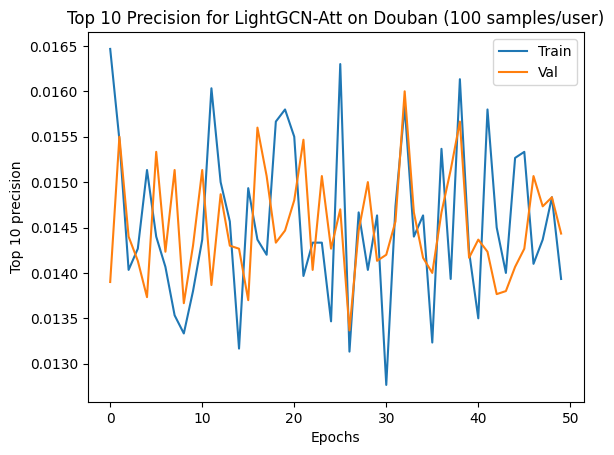

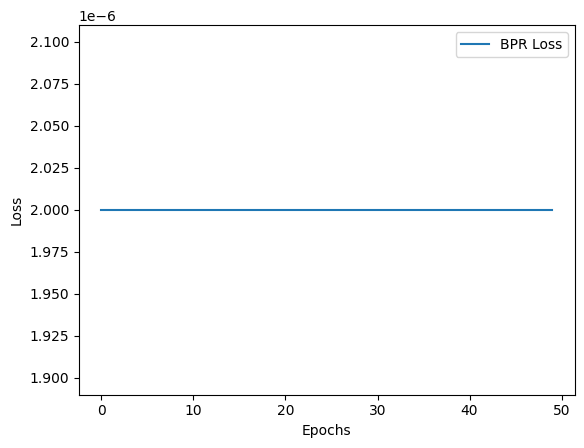

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(epochs_tracked, [precision for precision, _ in train_topks],
         label="Train")
plt.plot(epochs_tracked, [precision for precision, _ in val_topks],
         label="Val")
#plt.plot(epochs_tracked, [loss for loss in bprs],
#         label="BPR Loss")
plt.ylabel(f"Top {K} precision")
plt.xlabel("Epochs")
plt.legend()
plt.title("Top 10 Precision for LightGCN-Att on Douban (100 samples/user)")
plt.show()

plt.plot(epochs_tracked, [loss for loss in bprs],
         label="BPR Loss")
plt.ylabel(f"Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# Test

In [22]:
# predict on the test set
lightGCN.eval()
print("Training completed after {} epochs".format(epochs))

users_test = samples_test[:, 0:1]
pos_test = samples_test[:, 1:2]
neg_test = samples_test[:, 2:3]

loss_test, reg_loss_test = bpr_loss(
    lightGCN, users_test, pos_test, neg_test, mov, test_mask)
reg_loss_test = reg_loss_test * weight_decay

# predict on the test set
user_indices = samples_test[:, 0]
user_indices = user_indices.repeat(2).long()
item_indices = torch.cat((samples_test[:, 1], samples_test[:, 2])).long()
pred_test = getUsersRating(lightGCN, users_test[:,0], mov)\
    [user_indices, item_indices]
truth_test = global_edge_index[users_test.long()[:,0]]\
    [user_indices, item_indices]
test_topk_precision, test_topk_recall = personalized_topk(
    pred_test, K, user_indices, global_edge_index)

print("Average bpr_loss on the test set is {}, and regularization loss is {}.\n".format(round(float((loss_test+reg_loss_test)/len(samples_test)), 6),
                                                                                                round(float(reg_loss_test/len(samples_test)), 6)),
      "Top K precision = {}, recall = {}.".format(test_topk_precision, test_topk_recall))

# Save model embeddings.
torch.save(lightGCN, config_dict["model_name"])

Training completed after 50 epochs
Average bpr_loss on the test set is 2e-06, and regularization loss is 0.0.
 Top K precision = 0.01396666666666676, recall = 0.0059278283357094225.


# Baseline:

In [21]:
from tensorly import decomposition

def matrix_factorization(user_item, rank):
    """Runs matrix factorization on `user_item` and get user-item similarities.

    Args:
        user_item: User-item connectivity matrix.
        rank: Number of numbers to represent a user / item.

    Returns:
        User-item similarities.
    """
    weights, (user_factors, item_factors) = \
        decomposition.parafac(user_item, rank)
    similarities = user_factors @ item_factors.T
    return 1 / (1 + np.exp(- similarities))

# Compute baseline metrics using matrix factorization.
user_indices = samples_test[:, 0]
user_indices = user_indices.repeat(2).long()
item_indices = torch.cat((samples_test[:, 1], samples_test[:, 2])).long()
baseline_pred = matrix_factorization(
        global_edge_index.detach().cpu().numpy(),
        config_dict["mf_rank"])[user_indices.cpu(), item_indices.cpu()]
baseline_topk_precision, baseline_topk_recall = \
        personalized_topk(baseline_pred, config_dict["K"], user_indices, global_edge_index)
print("Baseline (PARAFAC matrix factorization) produces ",
      "Top K precision = {}, recall = {}.".format(baseline_topk_precision,
                                                  baseline_topk_recall))

Baseline (PARAFAC matrix factorization) produces  Top K precision = 0.014866666666666771, recall = 0.00645557951088146.
